# <center>Projet 7 : Implémentez un modèle de scoring

Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

# 1. Importation des modules, fonctions et données

## 1.1 Modules

In [1]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
import numpy as np
import pandas as pd
import os
import pickle
from collections import Counter


# Visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Data pré-processing
import sklearn
from sklearn.preprocessing import StandardScaler

# Oversampling
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
# UnderSampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Modelisation
# Préparation
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_validate, RandomizedSearchCV, \
    GridSearchCV, learning_curve  # , cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, fbeta_score, \
    precision_score, roc_auc_score, average_precision_score

# Modèles
import pycaret
from pycaret.classification import *
from sklearn.dummy import DummyClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Métriques
from sklearn.metrics import roc_auc_score, average_precision_score, \
    fbeta_score, make_scorer

# Interprétation
import shap

# Warnings
import warnings
from warnings import simplefilter

In [2]:
#Affichage des lignes et colonnes
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

## 1.2 Fonctions

In [3]:
def process_classification(model, X_train, X_valid, y_train, y_valid,
                           df_resultats, titre, affiche_res=True,
                           affiche_matrice_confusion=True):
    """
    Lance un modele de classification binaire, effectue cross-validation
    et sauvegarde des scores.
    Parameters
    ----------
    X_train : train set matrice X.
    X_valid : test set matrice X.
    y_train : train set vecteur y.
    y_valid : test set, vecteur y.
    df_resultats : dataframe sauvegardant les scores.
    -------
    df_resultats : Le dataframe de sauvegarde des performances.
    y_pred : Les prédictions pour le modèle
    """
    # Top début d'exécution
    time_start = time.time()

    # Entraînement du modèle avec le jeu d'entraînement du jeu d'entrainement
    model.fit(X_train, y_train)

    # Sauvegarde du modèle de classification entraîné
    with open('C:\\Users\\Marwa\\Downloads\\Projet7\\modele_' + titre + '.pickle', 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)
    
    # Top fin d'exécution
    time_end_train = time.time()
    
    # Prédictions avec le jeu de validation du jeu d'entraînement
    y_pred = model.predict(X_valid)

    # Top fin d'exécution
    time_end = time.time()

    # Probabilités
    y_proba = model.predict_proba(X_valid)[:, 1]
    
    # Calcul des métriques
    # Rappel/recall sensibilité
    recall = recall_score(y_valid, y_pred)
    # Précision
    precision = precision_score(y_valid, y_pred)
    # F-mesure ou Fbeta
    f1_score = fbeta_score(y_valid, y_pred, beta=1)
    f5_score = fbeta_score(y_valid, y_pred, beta=5)
    f10_score = fbeta_score(y_valid, y_pred, beta=10)
    # Score ROC AUC aire sous la courbe ROC
    roc_auc = roc_auc_score(y_valid, y_proba)
    # Score PR AUC aire sous la courbe précion/rappel
    pr_auc = average_precision_score(y_valid, y_proba)

    # durée d'exécution d'entraînement
    time_exec_train = time_end_train - time_start
    # durée d'exécution entraînement + validation
    time_execution = time_end - time_start

    # cross validation
    scoring = ['roc_auc', 'recall', 'precision']
    scores = cross_validate(model, X_train, y_train, cv=10,
                            scoring=scoring, return_train_score=True)

    # Sauvegarde des performances
    df_resultats = df_resultats.append(pd.DataFrame({
        'Modèle': [titre],
        'Rappel': [recall],
        'Précision': [precision],
        'F1': [f1_score],
        'F5': [f5_score],
        'F10': [f10_score],
        'ROC_AUC': [roc_auc],
        'PR_AUC': [pr_auc],
        'Durée_train': [time_exec_train],
        'Durée_tot': [time_execution],
    }), ignore_index=True)

    # Sauvegarde du tableau de résultat
    with open('C:\\Users\\Marwa\\Downloads\\Projet7\\df_resultat_scores.pickle', 'wb') as df:
        pickle.dump(df_resultats, df, pickle.HIGHEST_PROTOCOL)
    
    if affiche_res:
        mask = df_resultats['Modèle'] == titre
        display(df_resultats[mask].style.hide_index())

    if affiche_matrice_confusion:
        afficher_matrice_confusion(y_valid, y_pred, titre)

    return df_resultats

In [4]:
def sauvegarder_taux(titre_modele, FN, FP, TP, TN, df_taux):
    """
    df_taux : Le dataframe de sauvegarde des taux.
    ----------
    FN : nombre de faux négatifs.
    FP : nombre de faux positifs.
    TN : train set vecteur y.
    TP : test set, vecteur y.
    df_taux : dataframe sauvegardant les taux
    """

    # Sauvegarde des performances
    df_taux = df_taux.append(pd.DataFrame({
        'Modèle': [titre_modele],
        'FN': [FN],
        'FP': [FP],
        'TP': [TP],
        'TN': [TN],
        'fonction_cout' : [10*FN+FP]
    }), ignore_index=True)

    # Sauvegarde du tableau de résultat
    with open('C:\\Users\\Marwa\\Downloads\\Projet7\\df_taux.pickle', 'wb') as df:
        pickle.dump(df_taux, df, pickle.HIGHEST_PROTOCOL)
    
    return df_taux

In [5]:
def afficher_matrice_confusion(y_true, y_pred, title):

    plt.figure(figsize=(6, 4))

    cm = confusion_matrix(y_true, y_pred)
    
    labels = ['Non défaillants', 'Défaillants']
    
    sns.heatmap(cm,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d',
                cmap=plt.cm.Purples)
    plt.title(f'Matrice de confusion de : {title}')
    plt.ylabel('Classe réelle')
    plt.xlabel('Classe prédite')
    plt.show()  

## 1.3 Données

**Chargement des dataframes nettoyés et encodés**

<span style='background:Yellow'>**Avec 90% des variables importantes**</span>

In [6]:
fic_sav_train_set = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\train_fs_lightgbm.pickle'
# Chargement de train_set
with open(fic_sav_train_set, 'rb') as df_appli_train_set:
    train_set = pickle.load(df_appli_train_set)
train_set.shape

(307507, 184)

In [7]:
fic_sav_test_set = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\test_fs_lightgbm.pickle'
# Chargement de test_set
with open(fic_sav_test_set, 'rb') as df_appli_test_set:
    test_set = pickle.load(df_appli_test_set)
test_set.shape

(48744, 183)

<span style='background:Yellow'>**Avec 80% des variables importantes**</span>

In [8]:
fic_sav_train_set_80 = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\train_fs_lightgbm_80.pickle'
# Chargement de train_set
with open(fic_sav_train_set_80, 'rb') as df_appli_train_set_80:
    train_set_80 = pickle.load(df_appli_train_set_80)
train_set_80.shape

(307507, 127)

In [9]:
fic_sav_test_set_80 = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\test_fs_lightgbm_80.pickle'
# Chargement de test_set
with open(fic_sav_test_set_80, 'rb') as df_appli_test_set_80:
    test_set_80 = pickle.load(df_appli_test_set_80)
test_set_80.shape

(48744, 126)

# 2. Choix des modèles avec pycaret

Nous utiliserons Pycaret pour lancer les différents modèles de classification installés dans nos environnements pour classer les modèles qui semblent être les plus performants pour notre jeu de données et en prenant en compte les différents scores, sélectionner le modèle le plus prometteur.

<span style='background:Yellow'>**Avec 80% des features importants**</span>

In [10]:
# Classification PyCaret - Initialisation
exp_name_80 = setup(data=train_set_80,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_set_80',
                      silent=True)

,Description,Value
0,session_id,21
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(307507, 127)"
5,Missing Values,False
6,Numeric Features,123
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


2022/08/24 11:55:59 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



In [11]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés
# sur notre environnement de développement
# Tri par score AUC
best_models = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9179,0.7681,0.0714,0.4482,0.1232,0.1033,0.1540,95.0020
xgboost,Extreme Gradient Boosting,0.9151,0.7532,0.0815,0.3807,0.1342,0.1088,0.1459,289.9660
lightgbm,Light Gradient Boosting Machine,0.9157,0.7499,0.0481,0.3424,0.0843,0.0657,0.1028,13.9250
rf,Random Forest Classifier,0.9106,0.7288,0.0579,0.2600,0.0947,0.0672,0.0890,111.6170
et,Extra Trees Classifier,0.8989,0.7180,0.1251,0.2494,0.1666,0.1191,0.1272,50.5630
lda,Linear Discriminant Analysis,0.7197,0.7172,0.5845,0.1605,0.2519,0.1433,0.1890,11.1680
gbc,Gradient Boosting Classifier,0.8985,0.7086,0.1083,0.2282,0.1469,0.1001,0.1080,408.6250
ada,Ada Boost Classifier,0.8642,0.6813,0.1991,0.1844,0.1914,0.1174,0.1175,87.0010
knn,K Neighbors Classifier,0.6969,0.5592,0.3569,0.1029,0.1598,0.0394,0.0508,71.2770
dt,Decision Tree Classifier,0.8170,0.5515,0.2349,0.1352,0.1716,0.0771,0.0808,27.6520


In [12]:
# Le meilleur modèle ?
print(best_models)

In [13]:
# Sauvegarde des scores
df_best_models_scores_80 = pull()
df_best_models_scores_80

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9179,0.7681,0.0714,0.4482,0.1232,0.1033,0.1540,95.002
xgboost,Extreme Gradient Boosting,0.9151,0.7532,0.0815,0.3807,0.1342,0.1088,0.1459,289.966
lightgbm,Light Gradient Boosting Machine,0.9157,0.7499,0.0481,0.3424,0.0843,0.0657,0.1028,13.925
rf,Random Forest Classifier,0.9106,0.7288,0.0579,0.2600,0.0947,0.0672,0.0890,111.617
et,Extra Trees Classifier,0.8989,0.7180,0.1251,0.2494,0.1666,0.1191,0.1272,50.563
lda,Linear Discriminant Analysis,0.7197,0.7172,0.5845,0.1605,0.2519,0.1433,0.1890,11.168
gbc,Gradient Boosting Classifier,0.8985,0.7086,0.1083,0.2282,0.1469,0.1001,0.1080,408.625
ada,Ada Boost Classifier,0.8642,0.6813,0.1991,0.1844,0.1914,0.1174,0.1175,87.001
knn,K Neighbors Classifier,0.6969,0.5592,0.3569,0.1029,0.1598,0.0394,0.0508,71.277
dt,Decision Tree Classifier,0.8170,0.5515,0.2349,0.1352,0.1716,0.0771,0.0808,27.652


In [14]:
# Sauvegarde des scores des best models du train_set
fic_sav_train_set_scores_80 = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\pycaret_train_set_scores_80.pickle'
with open(fic_sav_train_set_scores_80, 'wb') as f:
    pickle.dump(df_best_models_scores_80, f, pickle.HIGHEST_PROTOCOL)

<span style='background:Yellow'>**Avec 90% des features importants**</span>

In [15]:
# Classification PyCaret - Initialisation
exp_name = setup(data=train_set,
                 target='TARGET',
                 fix_imbalance=True,
                 data_split_stratify=True,
                 session_id=21,
                 log_experiment=True,
                 experiment_name='train_set',
                 silent=True)

,Description,Value
0,session_id,21
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(307507, 184)"
5,Missing Values,False
6,Numeric Features,178
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés
# sur notre environnement de développement
# Tri par score AUC
best_models = compare_models(sort='AUC')

IntProgress(value=0, description='Processing: ', max=84)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:25:05
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9140,0.7266,0.0370,0.2656,0.0649,0.0461,0.0723,163.5940
ada,Ada Boost Classifier,0.8759,0.6815,0.1639,0.1894,0.1756,0.1089,0.1093,152.0920
knn,K Neighbors Classifier,0.6958,0.5585,0.3601,0.1032,0.1605,0.0400,0.0517,387.9630
dt,Decision Tree Classifier,0.8264,0.5504,0.2213,0.1389,0.1707,0.0794,0.0820,50.9940
lr,Logistic Regression,0.7809,0.5449,0.2403,0.1097,0.1504,0.0446,0.0491,24.5670
nb,Naive Bayes,0.0988,0.5416,0.9793,0.0808,0.1493,0.0001,0.0016,9.5700
qda,Quadratic Discriminant Analysis,0.5544,0.5338,0.4856,0.0910,0.1422,0.0177,0.0300,17.7350
svm,SVM - Linear Kernel,0.5048,0.0000,0.5685,0.0964,0.1576,0.0275,0.0431,54.2750
ridge,Ridge Classifier,0.7453,0.0000,0.4908,0.1565,0.2373,0.1309,0.1619,8.3770


In [ ]:
# Le meilleur modèle ?
print(best_models)

Faute du temps d'exécution de modèle pour le dataset avec 184 features, nous étions obligé d'interompre le noyau.
On travaillera alors uniquement sur le dataset avec 123 features (80% de feature importance)

### Bilan

In [10]:
# Scores du train_set 80% des features
fic_train_set_scores_80 = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\pycaret_train_set_scores_80.pickle'
# Chargement de train_set
with open(fic_train_set_scores_80, 'rb') as df_pycaret_train_set_80:
    df_best_models_scores_80 = pickle.load(df_pycaret_train_set_80)
df_best_models_scores_80.shape

(16, 9)

In [11]:
# Ajout du jeu de données pour identifier les scores
df_best_models_scores_80['Jeu_donnees'] = 'train_set_80'

In [12]:
# Tri avec métrique AUC
df_tri = df_best_models_scores_80.sort_values(by='AUC', ascending=False)
df_tri

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Jeu_donnees
catboost,CatBoost Classifier,0.9179,0.7681,0.0714,0.4482,0.1232,0.1033,0.1540,95.002,train_set_80
xgboost,Extreme Gradient Boosting,0.9151,0.7532,0.0815,0.3807,0.1342,0.1088,0.1459,289.966,train_set_80
lightgbm,Light Gradient Boosting Machine,0.9157,0.7499,0.0481,0.3424,0.0843,0.0657,0.1028,13.925,train_set_80
rf,Random Forest Classifier,0.9106,0.7288,0.0579,0.2600,0.0947,0.0672,0.0890,111.617,train_set_80
et,Extra Trees Classifier,0.8989,0.7180,0.1251,0.2494,0.1666,0.1191,0.1272,50.563,train_set_80
lda,Linear Discriminant Analysis,0.7197,0.7172,0.5845,0.1605,0.2519,0.1433,0.1890,11.168,train_set_80
gbc,Gradient Boosting Classifier,0.8985,0.7086,0.1083,0.2282,0.1469,0.1001,0.1080,408.625,train_set_80
ada,Ada Boost Classifier,0.8642,0.6813,0.1991,0.1844,0.1914,0.1174,0.1175,87.001,train_set_80
knn,K Neighbors Classifier,0.6969,0.5592,0.3569,0.1029,0.1598,0.0394,0.0508,71.277,train_set_80
dt,Decision Tree Classifier,0.8170,0.5515,0.2349,0.1352,0.1716,0.0771,0.0808,27.652,train_set_80


**Interprétation** : 

   - les jeux de données train_set/test_set seront utilisés pour entraîner et valider le modèle.
   - En se basant sur la métrique AUC, 3 modèles se détachent :
    - Catboost Classifier,
    - Light Gradient Boosting Machine,
    - Extreme Gradient Boosting Machine.
   - Observons alors les autres métriques pour départager nos 3 modèles.

In [13]:
mask_model = df_best_models_scores_80['Model'] \
    .isin(['CatBoost Classifier', 'Light Gradient Boosting Machine',
           'Extreme Gradient Boosting'])
mask_jeu = \
    df_best_models_scores_80['Jeu_donnees'].isin(['train_set_80'])
df_compare = df_best_models_scores_80[mask_model & mask_jeu]

**Choix du modèle**

- Pour notre problématique :
    - les **défaillants** forment la classe **positive**,
    - les **non-défaillants** forment la classe **négative**.
- Pour minimiser les pertes d'argent, nous devons :
    - nous efforcer de ne pas prédire un client non-défaillant s'il est défaillant ==> **minimiser le nombre de faux négatifs** (prédit non-défaillant mais client défaillant).
    - nous efforcer de ne pas prédire de défaillant si le client n'est pas défaillant donc **minimiser les faux positifs** (classe 1 défaillant alors que non-défaillant dans la réalité).
    
- La métrique pour déterminer le **taux de vrais positif** est le Rappel/**Recall**, elle mesure parmi toutes les observations positives combien ont été classées comme positives. Pour ne pas avoir de pertes, il faut détecter tous les défaillants (classe positive) donc **maximiser la métrique recall**.

In [14]:
# Tri avec métrique AUC
df_compare.groupby(['Model','Jeu_donnees']).agg({'AUC' : max}) \
    .sort_values(by=['Model', 'AUC'], ascending=[True, False]).unstack()

,AUC
Jeu_donnees,train_set_80
Model,
CatBoost Classifier,0.7681
Extreme Gradient Boosting,0.7532
Light Gradient Boosting Machine,0.7499


- Léger avantage au modèle Catboost, Lightgbm et xgboost ont des résultats proches.

In [15]:
# Tri avec métrique Recall
df_compare.groupby(['Model','Jeu_donnees']).agg({'Recall' : max}) \
    .sort_values(by=['Model', 'Recall'], ascending=[True, False]).unstack()

,Recall
Jeu_donnees,train_set_80
Model,
CatBoost Classifier,0.0714
Extreme Gradient Boosting,0.0815
Light Gradient Boosting Machine,0.0481


- Le meilleur résultat est obtenu par Xgboost, suivi par CatBoost avec un résultat 2 fois meilleur que pour Lightgbm mais le recall peut-être affiné en optimisant le modèle.

In [16]:
# Tri avec métrique Precision
df_compare.groupby(['Model','Jeu_donnees']).agg({'Prec.' : max}) \
    .sort_values(by=['Model', 'Prec.'], ascending=[True, False]).unstack()

,Prec.
Jeu_donnees,train_set_80
Model,
CatBoost Classifier,0.4482
Extreme Gradient Boosting,0.3807
Light Gradient Boosting Machine,0.3424


- Le meilleur résultat est obtenu par CatBoost, suivi par les 2 autres modèles qui ont des résultats proches.

In [17]:
# Tri avec métrique F1-Score
df_compare.groupby(['Model','Jeu_donnees']).agg({'F1' : max}) \
    .sort_values(by=['Model', 'F1'], ascending=[True, False]).unstack()

,F1
Jeu_donnees,train_set_80
Model,
CatBoost Classifier,0.1232
Extreme Gradient Boosting,0.1342
Light Gradient Boosting Machine,0.0843


- Le meilleur résultat est obtenu par Xgboost, suivi par Catboost, puis Lightgbm.

In [18]:
# Tri avec métrique Temps
df_compare.groupby(['Model','Jeu_donnees']).agg({'TT (Sec)' : max}) \
    .sort_values(by=['Model', 'TT (Sec)'], ascending=[True, False]).unstack()

,TT (Sec)
Jeu_donnees,train_set_80
Model,
CatBoost Classifier,95.002
Extreme Gradient Boosting,289.966
Light Gradient Boosting Machine,13.925


- Lightgbm est le plus rapide (22 fois plus rapide que xgboost et 7 fois plus que Catboost).

**Interprétation** :

- Les résultats sont meilleurs pour Catboost mais légèrement supérieur pour Xgboost par rapport à Lightgbm, mais le modèle Lightgbm est 7 fois plus rapide que Catboost. Puisque le but est un dashboard interactif, si de nouvelles données sont fournies ou si les données des clients évoluent, le temps d'exécution sera un facteur essentiel pour notre problématique.
- Après analyse des résultats, le modèle retenu sera Lightgbm.

**Choix du jeu de données**

In [19]:
mask_model = df_best_models_scores_80['Model'] == 'Light Gradient Boosting Machine'
mask_jeu = \
    df_best_models_scores_80['Jeu_donnees'].isin(['train_set_80'])
df_compare_jeu = df_best_models_scores_80[mask_model & mask_jeu]
df_compare_jeu

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Jeu_donnees
lightgbm,Light Gradient Boosting Machine,0.9157,0.7499,0.0481,0.3424,0.0843,0.0657,0.1028,13.925,train_set_80


# 3. Préparation du dataset

## 3.1. Découpage du dataset

**Nombre aléatoire**

In [20]:
# Nombre aléatoire pour la reproductibilité des résultats
seed = 21
print(f'Nombre aléatoire : {seed}')

Nombre aléatoire : 21


**Vecteur y**

In [21]:
# Vecteur y cible
y = train_set_80['TARGET']
print(f'y : {y.shape}')

y : (307507,)


**Matrice X**

In [22]:
# Matrice X
# Copie du jeu de données
train_set = train_set_80.copy(deep=True)
# Passage de l'identifiant du client en index pour la modélisation
train_set.set_index('SK_ID_CURR', inplace=True)
# Suppression de la variable cible pour la modélisation
X = train_set.drop(['TARGET'], axis=1)
print(f'X : {X.shape}')

X : (307507, 125)


**Découpage du jeu d'entraînement**

In [23]:
# Découpage du jeu d'entraînement en :
# X_train : pour entraîner le modèle et trouver les meilleurs
#           hyperparamètres
# X_valid : pour évaluer les performances du modèle
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.2,
                                                      shuffle=True,
                                                      stratify=y,
                                                      random_state=seed)
print(f'X_train : {X_train.shape} - y_train : {y_train.shape}')
print(f'X_valid : {X_valid.shape} - y_valid : {y_valid.shape}')

X_train : (246005, 125) - y_train : (246005,)
X_valid : (61502, 125) - y_valid : (61502,)


## 3.2 Choix des métriques

Différentes métriques existent pour les modélisations de classification binaire :
    
**Métriques**
***
-  **Recall** : la métrique pour déterminer le **taux de vrais positif** est le Rappel(Sensibilité)/**Recall**, elle mesure parmi toutes les observations positives combien ont été classées comme positives. Pour ne pas avoir de pertes, il faut détecter tous les défaillants (classe positive) donc **maximiser la métrique recall**.

- **Precision** : elle mesure le nombre d'observations prédites comme positives (client défaillant) qui le sont en réalité. Si le client est prédit défaillant alors qu'il ne le sera pas le prêt ne sera pas accordé et les intérêts ne seront pas empochés. Il faut donc **maximiser la 'Precision'**.

- **F-mesure ou F1** : compromis entre le rappel et précision.
    -  Si on augmente le recall, la précision diminue, il s'agit de faire un compromis entre ces 2 métriques qui dépendent l'une de l'autre.
    - Dans notre cas, il faut trouver le plus grand nombre d'observations réellement positives (client prédit défaillant et bien défaillant) et la perte est moins grande si on prédit un client défaillant mais qu'il n'est pas défaillant (faux positifs), donc **on donnera priorité à maximiser le recall au dépend de la précision** (on parle bien de Precision pas d'accuracy).
    - Le réglage du paramètre beta pour le Fbeta score permet de donner plus de poids au recall (beta>1) qu'à la précision (0<beta<1). Le score F1 est la moyenne harmonique entre le recall et la précision.

- **Score ROC AUC** : le score ROC AUC est équivalent au calcul de la corrélation de rang entre les prédictions et la cible. Du point de vue de l'interprétation, il est plus utile car il nous indique que cette métrique montre à quel point votre modèle est bon pour classer les prédictions. Elle vous indique la probabilité qu'une instance positive choisie au hasard soit classée plus haut qu'une instance négative choisie au hasard.

- **Score PR AUC** : calcule de l'aire sous la courbe précision-rappel pour obtenir un nombre qui vous donne des informations sur la performance du modèle.

**NB :**

- La librairie sklearn permet de calculer tous ses scores.

# 4. Modélisation

In [24]:
df_resultats = pd.DataFrame({})

In [25]:
df_taux = pd.DataFrame({})

In [26]:
# Sauvegarde des scores des best models du train_set
fic_sav_set_scores = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\df_resultat_scores.pickle'
with open(fic_sav_set_scores, 'wb') as f:
    pickle.dump(df_best_models_scores_80, f, pickle.HIGHEST_PROTOCOL)

In [27]:
# Chargement du dataframe de sauvegardes des scores des modèles
fic_df_resultat_scores = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\df_resultat_scores.pickle'
with open(fic_df_resultat_scores, 'rb') as df_resultat_scores:
    df_resultats = pickle.load(df_resultat_scores)

In [28]:
# Sauvegarde des scores des taux
fic_taux = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\df_taux.pickle'
with open(fic_taux, 'wb') as f:
    pickle.dump(df_taux, f, pickle.HIGHEST_PROTOCOL)

In [29]:
# Chargement du dataframe de sauvegardes des différents taux :
# TN : vrais négatifs, TP : vrais positifs
# FP : faux positifs, FN : faux négatifs
fic_df_taux = 'C:\\Users\\Marwa\\Downloads\\Projet7\\df_taux.pickle'
with open(fic_df_taux, 'rb') as df_taux:
    df_taux = pickle.load(df_taux)

In [30]:
# Métriques
roc_auc = make_scorer(roc_auc_score, greater_is_better=True,
                      needs_proba=True)
pr_auc = make_scorer(average_precision_score, greater_is_better=True,
                     needs_proba=True)
f1_score = make_scorer(fbeta_score, beta=1, greater_is_better=True)
f5_score = make_scorer(fbeta_score, beta=5, greater_is_better=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

## 4.1 Baseline : DummyClassifier

Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par Dummy Classifier permettra d'obtenir une baseline.

Les résultats constitue la baseline pour comparer les modèles optimisés.

**Sans Rééquilibrage**

In [31]:
# Initialisation du modèle avec les hyperparamètres de base
Dummy_prior = DummyClassifier(random_state=seed)

Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Jeu_donnees,Modèle,Rappel,Précision,F5,F10,ROC_AUC,PR_AUC,Durée_train,Durée_tot
nan,nan,nan,nan,nan,0.084960,nan,nan,nan,nan,Dummy_prior,0.084592,0.085331,0.084620,0.084599,0.502481,0.081118,0.007999,0.012000


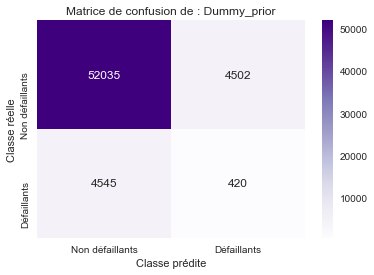

In [32]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(Dummy_prior, X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'Dummy_prior')

In [33]:
# Sauvegarde
df_taux = sauvegarder_taux('Dummy_prior',
                                        4545, 4502, 420, 52035, df_taux)

**sans rééquilibrage : strategy ="most_frequent"**

In [34]:
# Initialisation du modèle avec les hyperparamètres de base
Dummy_freq = DummyClassifier(random_state=seed, strategy="most_frequent")

Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Jeu_donnees,Modèle,Rappel,Précision,F5,F10,ROC_AUC,PR_AUC,Durée_train,Durée_tot
nan,nan,nan,nan,nan,0.000000,nan,nan,nan,nan,Dummy_freq,0.000000,0.000000,0.000000,0.000000,0.500000,0.080729,0.011001,0.011001


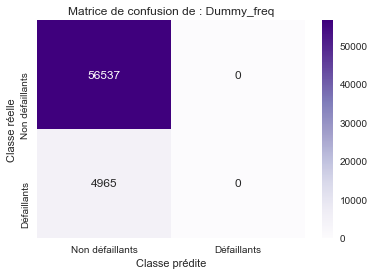

In [35]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(Dummy_freq, X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'Dummy_freq')

In [36]:
# Sauvegarde
df_taux = sauvegarder_taux('Dummy_freq',
                                        4965, 0, 0, 56537, df_taux)

**sans rééquilibrage : strategy = 'stratified'**

In [37]:
# Initialisation du modèle avec les hyperparamètres de base
Dummy_stratified = DummyClassifier(random_state=seed, strategy="stratified")

Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Jeu_donnees,Modèle,Rappel,Précision,F5,F10,ROC_AUC,PR_AUC,Durée_train,Durée_tot
nan,nan,nan,nan,nan,0.084960,nan,nan,nan,nan,Dummy_stratified,0.084592,0.085331,0.084620,0.084599,0.502481,0.081118,0.009000,0.011002


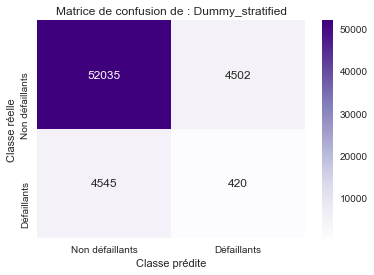

In [38]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(Dummy_stratified, X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'Dummy_stratified')

In [39]:
# Sauvegarde
df_taux = sauvegarder_taux('Dummy_stratified',
                                        4545, 4502, 420, 52035, df_taux)

**Rééquilibrage - oversampling : SMOTE auto**

Plusieurs méthodes de réquilibrage sont à notre disposition :
- undersampling : consiste en un sous-échantillonnage de la classe majoritaire.
- oversampling : sur-échantillonnage de la classe minoritaire (ex : SMOTE, ADASYN).
- une combinaison d'oversampling suivi d'undersampling (possible avec SMOTE).
- hyperparamètre du modèle Ligthgbm : class_weight='balanced'.

**Répartition variable TARGET**

In [40]:
# Jeu d'entraînement du jeu d'entraînement
# Répartition des la cible 0 (non-défaillants) - 1 (défaillants)?
y_train_distrib = Counter(y_train)
print('Répartition des classes : ')
print(y_train_distrib)
# Pourcentage
y_train_distrib_norm = y_train.value_counts(normalize=True)*100
print('\nRépartition des classes (en %) :')
print(y_train_distrib_norm)

Répartition des classes : 
Counter({0: 226145, 1: 19860})

Répartition des classes (en %) :
0    91.926993
1     8.073007
Name: TARGET, dtype: float64


In [41]:
# Jeu de validation du jeu d'entraînement
# Répartition des la cible 0 (non-défaillants) - 1 (défaillants)?
y_valid_distrib = Counter(y_valid)
print('Répartition des classes : ')
print(y_valid_distrib)
# Pourcentage
y_valid_distrib_norm = y_valid.value_counts(normalize=True)*100
print('\nRépartition des classes (en %) :')
print(y_valid_distrib_norm)

Répartition des classes : 
Counter({0: 56537, 1: 4965})

Répartition des classes (en %) :
0    91.927092
1     8.072908
Name: TARGET, dtype: float64


**Observations** :

- La variable cible est fortement déséquilibrée 90% de non défaillants et 10% de défaillants ==> on tentera un rééquilibrage de la variable cible pour optimiser le modèle.

In [42]:
# Répartition des classes au départ
counter_original = Counter(y_train)
print(counter_original)
# Application de l'oversampling via SMOTE avec les paramètres par défaut
oversample = SMOTE(sampling_strategy='auto', k_neighbors=5, n_jobs=-1,
                   random_state=seed)
X_train_smote_1, y_train_smote_1 = \
    oversample.fit_resample(X_train, y_train)
X_valid_smote_1, y_valid_smote_1 = \
    oversample.fit_resample(X_valid, y_valid)
# Répartition après oversampling SMOTE paramètres par défaut
counter_smote_1 = Counter(y_train_smote_1)
print(counter_smote_1)

Counter({0: 226145, 1: 19860})
Counter({0: 226145, 1: 226145})


In [43]:
# Initialisation du modèle avec les hyperparamètres de base
Dummy_smote = DummyClassifier(random_state=seed)

Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Jeu_donnees,Modèle,Rappel,Précision,F5,F10,ROC_AUC,PR_AUC,Durée_train,Durée_tot
nan,nan,nan,nan,nan,0.500994,nan,nan,nan,nan,Dummy_smote,0.501212,0.500778,0.501195,0.501207,0.500778,0.500390,0.023218,0.030906


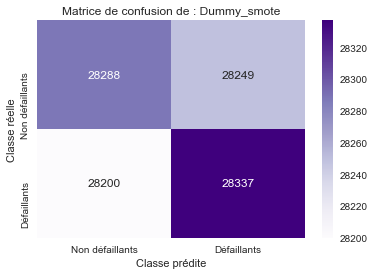

In [44]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(Dummy_smote,
                                        X_train_smote_1, X_valid_smote_1,
                                        y_train_smote_1, y_valid_smote_1,
                                        df_resultats,
                                        'Dummy_smote')

In [45]:
# Sauvegarde
df_taux = sauvegarder_taux('Dummy_smote',
                                        28200, 28249, 28337, 28288, df_taux)

Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Jeu_donnees,Modèle,Rappel,Précision,F5,F10,ROC_AUC,PR_AUC,Durée_train,Durée_tot
nan,nan,nan,nan,nan,0.084960,nan,nan,nan,nan,Dummy_smote_train,0.084592,0.085331,0.084620,0.084599,0.502481,0.081118,0.011213,0.013836


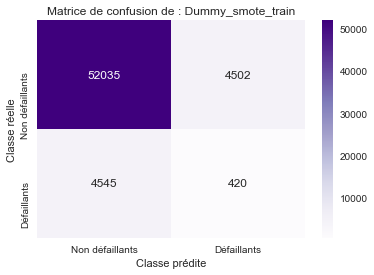

In [46]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(Dummy_smote,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'Dummy_smote_train')

In [47]:
# Sauvegarde
df_taux = sauvegarder_taux('Dummy_smote_train',
                                        4545, 4502, 420, 52035, df_taux)

## 4.2 Modèle LGBM

**Sans rééquilibrage**

In [48]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm = LGBMClassifier(random_state=seed, verbose=0,
                           force_col_wise=True)

Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Jeu_donnees,Modèle,Rappel,Précision,F5,F10,ROC_AUC,PR_AUC,Durée_train,Durée_tot
nan,nan,nan,nan,nan,0.076793,nan,nan,nan,nan,lgbm,0.041088,0.586207,0.042612,0.041469,0.780701,0.274174,5.079440,5.268857


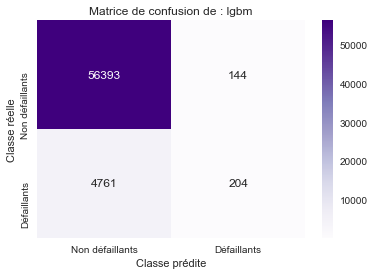

In [49]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm, X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm')

In [50]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm',
                                        4761, 144, 204, 56393, df_taux)

**Avec rééquilibrage : Class_weight**

In [51]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_class_weight = LGBMClassifier(random_state=seed, verbose=0,
                               force_col_wise=True,
                               class_weight='balanced')

Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Jeu_donnees,Modèle,Rappel,Précision,F5,F10,ROC_AUC,PR_AUC,Durée_train,Durée_tot
nan,nan,nan,nan,nan,0.290934,nan,nan,nan,nan,lgbm_class_weight,0.691239,0.184239,0.625080,0.672905,0.783809,0.279467,5.547102,5.737577


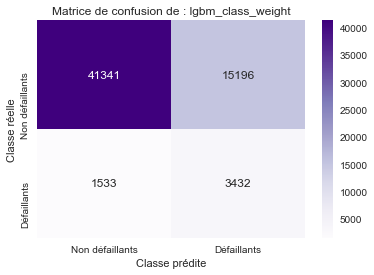

In [52]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_class_weight, X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_class_weight')

In [53]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_class_weight',
                                        1533, 15196, 3432, 41341, df_taux)

**Rééquilibrage : SMOTE**

In [54]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote = LGBMClassifier(random_state=seed, verbose=0,
                                   force_col_wise=True)

Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Jeu_donnees,Modèle,Rappel,Précision,F5,F10,ROC_AUC,PR_AUC,Durée_train,Durée_tot
nan,nan,nan,nan,nan,0.948651,nan,nan,nan,nan,lgbm_smote,0.912341,0.987971,0.915035,0.913033,0.976926,0.983450,11.191525,11.575442


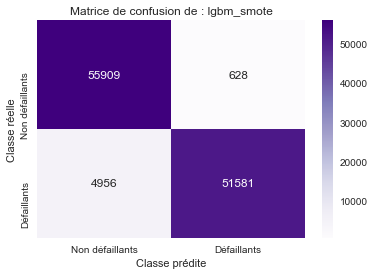

In [55]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_smote,
                                        X_train_smote_1, X_valid_smote_1,
                                        y_train_smote_1, y_valid_smote_1,
                                        df_resultats,
                                        'lgbm_smote')

In [56]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_smote',
                                        4956, 628, 51581, 55909, df_taux)

Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Jeu_donnees,Modèle,Rappel,Précision,F5,F10,ROC_AUC,PR_AUC,Durée_train,Durée_tot
nan,nan,nan,nan,nan,0.076793,nan,nan,nan,nan,lgbm_smote_train,0.041088,0.586207,0.042612,0.041469,0.780701,0.274174,5.617823,5.831635


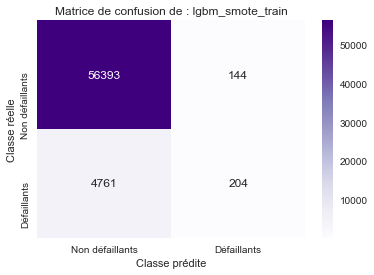

In [57]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_smote,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_train')

In [58]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_smote_train',
                                        4761, 144, 204, 56393, df_taux)

## 4.3. LGBM - StandardScaler

Normalement les modèles à base d'arbres décisionnels n'utilisant pas les distances ne nécessitent pas de données standardisées. La plupart des notebooks Kaggle utilisant la modélisation LightGBM utilise les données standardisées sans l'expliquer. Est-ce que cela peut avoir un fort impact sur notre modèle? Nous observerons l'impact de la standardisation sur notre jeu de données standardisé avec le modèle LightGBM de base.

In [59]:
# StandardScaler
scaler_std = StandardScaler()

# Jeu d'entraînement du jeu d'entraînement
X_train_std = scaler_std.fit_transform(X_train.copy(deep=True))
# Jeu de validation du jeu d'entraînement
X_valid_std = scaler_std.transform(X_valid.copy(deep=True))

# Sauvegarde de la standardisation
with open('C:\\Users\\Marwa\\Downloads\\Projet7\\standardisation_std.pickle', 'wb') as f:
    pickle.dump(scaler_std, f, pickle.HIGHEST_PROTOCOL)

**Sans rééquilibrage**

In [60]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_std = LGBMClassifier(random_state=seed, verbose=0,
                               force_col_wise=True)

Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Jeu_donnees,Modèle,Rappel,Précision,F5,F10,ROC_AUC,PR_AUC,Durée_train,Durée_tot
nan,nan,nan,nan,nan,0.076880,nan,nan,nan,nan,lgbm_std,0.041289,0.557065,0.042814,0.041671,0.780599,0.273492,5.754732,5.910632


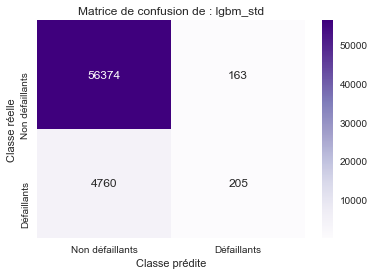

In [61]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_std, X_train_std,
                                        X_valid_std, y_train, y_valid,
                                        df_resultats,
                                        'lgbm_std')

In [62]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_std',
                                        4760, 163, 205, 56374, df_taux)

**Avec rééquilibrage**

In [63]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_std_bal = LGBMClassifier(random_state=seed, verbose=0,
                                   force_col_wise=True,
                                   class_weight='balanced')

Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Jeu_donnees,Modèle,Rappel,Précision,F5,F10,ROC_AUC,PR_AUC,Durée_train,Durée_tot
nan,nan,nan,nan,nan,0.291365,nan,nan,nan,nan,lgbm_std_class_weight,0.688419,0.184787,0.623102,0.670330,0.781991,0.275458,6.318755,6.507296


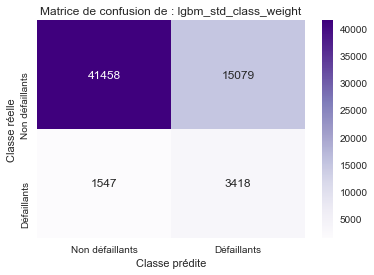

In [64]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_std_bal, X_train_std,
                                        X_valid_std, y_train, y_valid,
                                        df_resultats,
                                        'lgbm_std_class_weight')

In [65]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_std_class_weight',
                                        1547, 15079, 3418, 41458, df_taux)

**Observations** :

Le nombre de faux négatifs est légèrement plus faible(1533 au lieu de 1547) pour le jeux d'entraînement non standardisé. 

## 4.4 Optimisation LGBM : Pycaret - hyperopt

La mise en oeuvre de LightGBM est facile, la seule chose compliquée est le réglage des hyperparamètres. LightGBM couvre plus de 100 hyperparamètres. Dans le contexte du projet l’idée est de pouvoir optimiser quelques hyperparamètres via HyperOpt. il est nécessaire d’identifier des hyperparamètres pouvant avoir un impact dans l’amélioration de la métrique d’évaluation.

Grid Search ou Random Search étaient également une alternative possible, à la différence d'Hyperopt une "méthode basique" ne permet pas de traiter un large espace de paramètres, ici très largement privilégié.

Avec Hyperopt, on peut facilement analyser notre modèle de Boosting tout en variant les hyperparamètres dans l'espace que nous allons définir ci-dessous.

In [69]:
# Classification PyCaret - Initialisation
exp_name_Py = setup(data=train_set,
                      target='TARGET',
                      fix_imbalance=True,  # SMOTE
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_set',
                      silent=True,
                      n_jobs=1)

,Description,Value
0,session_id,21
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(307507, 126)"
5,Missing Values,False
6,Numeric Features,122
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [70]:
# Instanciation du modèle
# Cette fonction entraîne et évalue la performance d'un estimateur donné
# en utilisant la validation croisée.
# La sortie de cette fonction est une grille de score avec les scores CV
# par pli.
lgbm_pycaret = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9164,0.7594,0.0437,0.3568,0.0779,0.0614,0.1013
1,0.9161,0.7543,0.0495,0.3583,0.0870,0.0687,0.1082
2,0.9168,0.7590,0.0547,0.3893,0.0959,0.0775,0.1213
3,0.9163,0.7495,0.0495,0.3660,0.0872,0.0693,0.1100
4,0.9169,0.7469,0.0518,0.3879,0.0914,0.0738,0.1177
5,0.9155,0.7419,0.0518,0.3435,0.0900,0.0704,0.1071
6,0.9154,0.7445,0.0535,0.3444,0.0927,0.0725,0.1091
7,0.9153,0.7474,0.0432,0.3178,0.0760,0.0578,0.0916
8,0.9151,0.7447,0.0472,0.3228,0.0823,0.0630,0.0971


In [71]:
lgbm_tuned_hyperopt = tune_model(lgbm_pycaret,
                                 optimize='AUC',
                                 choose_better=True,
                                 search_library='tune-sklearn',
                                 search_algorithm='hyperopt',
                                 n_iter=20)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9122,0.7421,0.0535,0.2751,0.0896,0.0650,0.0901
1,0.9105,0.7299,0.0512,0.2432,0.0846,0.0581,0.0784
2,0.9120,0.7340,0.0610,0.2873,0.1006,0.0744,0.1001
3,0.9112,0.7325,0.0443,0.2348,0.0745,0.0502,0.0703
4,0.9124,0.7275,0.0507,0.2708,0.0854,0.0615,0.0864
5,0.9099,0.7249,0.0512,0.2336,0.0840,0.0567,0.0754
6,0.9115,0.7328,0.0501,0.2551,0.0837,0.0588,0.0813
7,0.9105,0.7312,0.0420,0.2179,0.0704,0.0455,0.0633
8,0.9111,0.7226,0.0518,0.2535,0.0860,0.0603,0.0821


In [72]:
print(lgbm_tuned_hyperopt)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=1, num_leaves=31, objective=None,
               random_state=21, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [73]:
plot_model(estimator=lgbm_tuned_hyperopt, plot='auc', save=True)

'AUC.png'

In [74]:
plot_model(estimator=lgbm_tuned_hyperopt,
           plot='confusion_matrix', save=True)

'Confusion Matrix.png'

In [75]:
plot_model(estimator=lgbm_tuned_hyperopt, plot='error', save=True)

'Prediction Error.png'

In [76]:
plot_model(estimator=lgbm_tuned_hyperopt, plot='class_report', save=True)

'Class Report.png'

In [77]:
print(lgbm_pycaret)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=1, num_leaves=31, objective=None,
               random_state=21, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [78]:
print(lgbm_tuned_hyperopt)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=1, num_leaves=31, objective=None,
               random_state=21, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [79]:
# Sauvegarde du model pycaret optimisé hyperopt
fic_pycaret_lgbm_hyperopt = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\pycaret_lgbm_hyperopt.pickle'
with open(fic_pycaret_lgbm_hyperopt, 'wb') as f:
    pickle.dump(lgbm_tuned_hyperopt, f, pickle.HIGHEST_PROTOCOL)

In [80]:
# Sauvegarde du model pycaret de base
fic_pycaret_lgbm = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\pycaret_lgbm.pickle'
with open(fic_pycaret_lgbm, 'wb') as f:
    pickle.dump(lgbm_pycaret, f, pickle.HIGHEST_PROTOCOL)

**visualisation**

![](AUC.png)

![](Confusion.png)

![](Error.png)

![](Class.png)

In [66]:
# Chargement du modèle pycaret LightGBM optimisé avec hyperopt
fic_pycaret_lgbm_hyperopt = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\pycaret_lgbm_hyperopt.pickle'
with open(fic_pycaret_lgbm_hyperopt, 'rb') as model_pycaret_lgbm_hyperopt:
    pycaret_lgbm_hyperopt = pickle.load(model_pycaret_lgbm_hyperopt)

Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Jeu_donnees,Modèle,Rappel,Précision,F5,F10,ROC_AUC,PR_AUC,Durée_train,Durée_tot
nan,nan,nan,nan,nan,0.076793,nan,nan,nan,nan,pycaret_lgbm_hyperopt,0.041088,0.586207,0.042612,0.041469,0.780701,0.274174,13.633338,14.116563


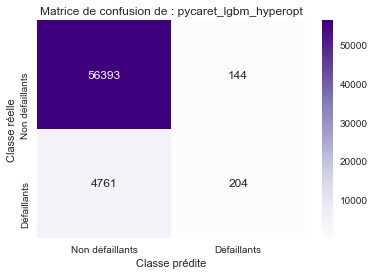

In [67]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(pycaret_lgbm_hyperopt,
                                        X_train, X_valid, y_train, y_valid,
                                        df_resultats,
                                        'pycaret_lgbm_hyperopt')

In [68]:
# Sauvegarde
df_taux = sauvegarder_taux('pycaret_lgbm_hyperopt',
                                        4761, 144, 204, 56393, df_taux)

**Interprétation**

Le modèle LGBM optimisé par Hyperopt de Pycart à donné le méme resultat que lgbm non optimisé.

## 4.5 Fonction cout

Dans le but de minimiser les erreurs de prédiction, une fonction coût ayant pour objectif de pénaliser les Faux Positifs et les Faux Négatifs a été implémentée.
- Beta = (coef Recall)/(coef Precision)
- fonction_cout = : 10*FN + FP

**Les différents taux des matrices de confusion**

In [69]:
df_taux_comp1 = df_taux.sort_values(by='Modèle')

In [70]:
modeles = ['Dummy_prior', 'Dummy_freq',
           'Dummy_stratified', 'Dummy_smote_train',
          'lgbm', 'lgbm_class_weight',
           'lgbm_smote_train', 'lgbm_std',
          'lgbm_std_class_weight', 'pycaret_lgbm_hyperopt']

In [71]:
jeu_donnees = ['train', 'train', 'train', 'train', 'train', 'train',
               'train', 'train', 'train', 'train']

In [72]:
df_taux_comp2 = pd.DataFrame({'Modèle' : modeles,
                              'Jeu_donnees' : jeu_donnees})

In [73]:
# Dataframe de sauvegarde des taux des différentes modélisations
df_taux_comp = df_taux_comp2.merge(df_taux_comp1, on='Modèle',
                                   how='right')

In [74]:
# Tri par Faux Négatifs décroissant (les clients prédits non défaillants
# qui sont défaillants ==> la banque perd le montant du prêt en totalité
# ou en partie) pour le train set
mask = df_taux_comp['Jeu_donnees'] == 'train'
df_taux_comp[mask].sort_values(by='FN').style \
    .highlight_min(subset=['FN', 'FP', 'TN', 'TP'], color='lightgreen',
                   axis=0)

,Modèle,Jeu_donnees,FN,FP,TP,TN,fonction_cout
6,lgbm_class_weight,train,1533,15196,3432,41341,30526
10,lgbm_std_class_weight,train,1547,15079,3418,41458,30549
1,Dummy_prior,train,4545,4502,420,52035,49952
3,Dummy_smote_train,train,4545,4502,420,52035,49952
4,Dummy_stratified,train,4545,4502,420,52035,49952
9,lgbm_std,train,4760,163,205,56374,47763
5,lgbm,train,4761,144,204,56393,47754
8,lgbm_smote_train,train,4761,144,204,56393,47754
11,pycaret_lgbm_hyperopt,train,4761,144,204,56393,47754
0,Dummy_freq,train,4965,0,0,56537,49650


**Constitution des dataframes de comparaison pour les résultats**

In [75]:
df_resultats_comp1 = df_resultats.sort_values(by='Modèle')

In [76]:
metrique = ['roc_auc', 'roc_auc', 'roc_auc', 'roc_auc', 'roc_auc',
            'roc_auc', 'roc_auc','roc_auc', 'roc_auc', 'roc_auc']

In [77]:
df_resultats_comp2 = pd.DataFrame({'Modèle' : modeles,
                                   'Metrique' : metrique})

In [78]:
# Dataframe de sauvegarde des résultats de la modélisation
df_resultats_comp = \
    df_resultats_comp2.merge(df_resultats_comp1, on='Modèle', how='left')

In [79]:
# Dataframe de recueil de tous les résultats
df_comparaison = \
    df_taux_comp.merge(df_resultats_comp, on='Modèle', how='left')

In [80]:
# Les vraies répartition de la TARGET dans le jeu de validation
Counter(y_valid)

Counter({0: 56537, 1: 4965})

- Nombre de vrais non-défaillants : 56537 (TN).
- Nombre de vrais défaillants : 4965 (TP).

In [81]:
df_comp = df_comparaison.sort_values(by='FN')
df_comp.style.highlight_min(subset=['FN', 'FP', 'TN', 'TP'],
                            color='lightgreen', axis=0).hide_index()

Modèle,Jeu_donnees_x,FN,FP,TP,TN,fonction_cout,Metrique,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Jeu_donnees_y,Rappel,Précision,F5,F10,ROC_AUC,PR_AUC,Durée_train,Durée_tot
lgbm_class_weight,train,1533,15196,3432,41341,30526,roc_auc,nan,nan,nan,nan,nan,0.290934,nan,nan,nan,nan,0.691239,0.184239,0.625080,0.672905,0.783809,0.279467,5.547102,5.737577
lgbm_std_class_weight,train,1547,15079,3418,41458,30549,roc_auc,nan,nan,nan,nan,nan,0.291365,nan,nan,nan,nan,0.688419,0.184787,0.623102,0.670330,0.781991,0.275458,6.318755,6.507296
Dummy_prior,train,4545,4502,420,52035,49952,roc_auc,nan,nan,nan,nan,nan,0.084960,nan,nan,nan,nan,0.084592,0.085331,0.084620,0.084599,0.502481,0.081118,0.007999,0.012000
Dummy_smote_train,train,4545,4502,420,52035,49952,roc_auc,nan,nan,nan,nan,nan,0.084960,nan,nan,nan,nan,0.084592,0.085331,0.084620,0.084599,0.502481,0.081118,0.011213,0.013836
Dummy_stratified,train,4545,4502,420,52035,49952,roc_auc,nan,nan,nan,nan,nan,0.084960,nan,nan,nan,nan,0.084592,0.085331,0.084620,0.084599,0.502481,0.081118,0.009000,0.011002
lgbm_std,train,4760,163,205,56374,47763,roc_auc,nan,nan,nan,nan,nan,0.076880,nan,nan,nan,nan,0.041289,0.557065,0.042814,0.041671,0.780599,0.273492,5.754732,5.910632
lgbm,train,4761,144,204,56393,47754,roc_auc,nan,nan,nan,nan,nan,0.076793,nan,nan,nan,nan,0.041088,0.586207,0.042612,0.041469,0.780701,0.274174,5.079440,5.268857
lgbm_smote_train,train,4761,144,204,56393,47754,roc_auc,nan,nan,nan,nan,nan,0.076793,nan,nan,nan,nan,0.041088,0.586207,0.042612,0.041469,0.780701,0.274174,5.617823,5.831635
pycaret_lgbm_hyperopt,train,4761,144,204,56393,47754,roc_auc,nan,nan,nan,nan,nan,0.076793,nan,nan,nan,nan,0.041088,0.586207,0.042612,0.041469,0.780701,0.274174,13.633338,14.116563
lgbm_smote,nan,4956,628,51581,55909,50188,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [100]:
# Sauvegarde du meilleur modèle dans best_model
fic_best_model = \
    'C:\\Users\\Marwa\\Downloads\\Projet7\\best_model.pickle'
with open(fic_best_model, 'wb') as f:
    pickle.dump(lgbm_class_weight, f, pickle.HIGHEST_PROTOCOL)

**Interprétation** :

- Le modèle **lgbm_class_weight** (LightGBM class_weight='balanced') détecte :
    - le moins de faux négatifs (des clients détectés non défaillants mais qui ne remboursent pas le prêt) 
    - et le plus de vrais positifs (des clients détéctés défaillants qui sont défaillants),
- Ce modèle est le meilleur modèle.
- Les différentes métriques sont proches pour tous les modèles **lgbm** avec un léger avantage pour le rappel pour le modèle **lgbm_class_weight**.

# 5. Interprétation du modèle : Méthode SHAP

- La méthode SHAP (SHapley Additive exPlanations) consiste à calculer la valeur de Shapley pour toutes les variables de tous les individus c’est-à-dire la moyenne de l’impact d’une variable (sur la sortie, donc la prédiction) pour toutes les combinaisons de variables possibles.
- La somme des effets de chaque variable expliquera la prédiction.

In [82]:
# Chargement du meilleur modèle
fic_best_model = 'C:\\Users\\Marwa\\Downloads\\Projet7\\best_model.pickle'
with open(fic_best_model, 'rb') as df_best_model:
    best_model = pickle.load(df_best_model)
best_model

LGBMClassifier(class_weight='balanced', force_col_wise=True, random_state=21,
               verbose=0)

**Globale**

**Summary plot**

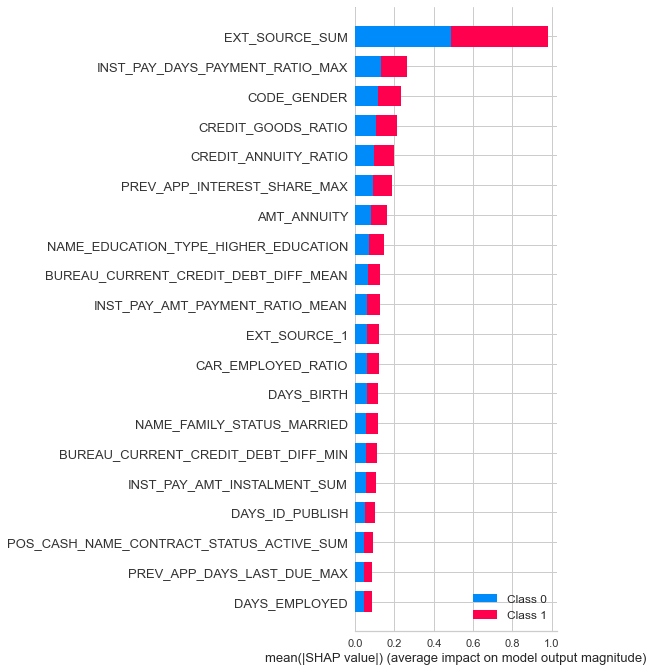

In [151]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_valid)
# Summary plot
shap.summary_plot(shap_values, X_valid)

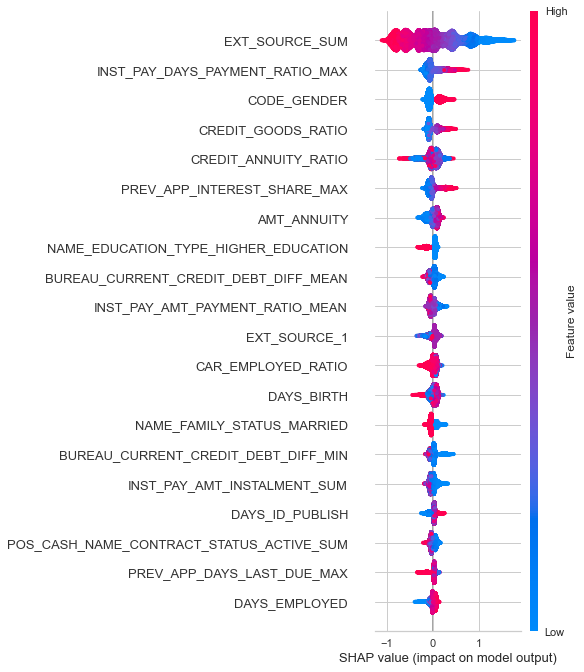

In [152]:
shap.summary_plot(shap_values[1], X_valid, show=False)

In [153]:
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_train, check_additivity=False)

100%|===================| 245927/246005 [16:12<00:00]        

**Bar plot** : l'importance globale des caractéristiques, où l'importance globale de chaque caractéristique est considérée comme la valeur absolue moyenne pour cette caractéristique sur tous les échantillons donnés.

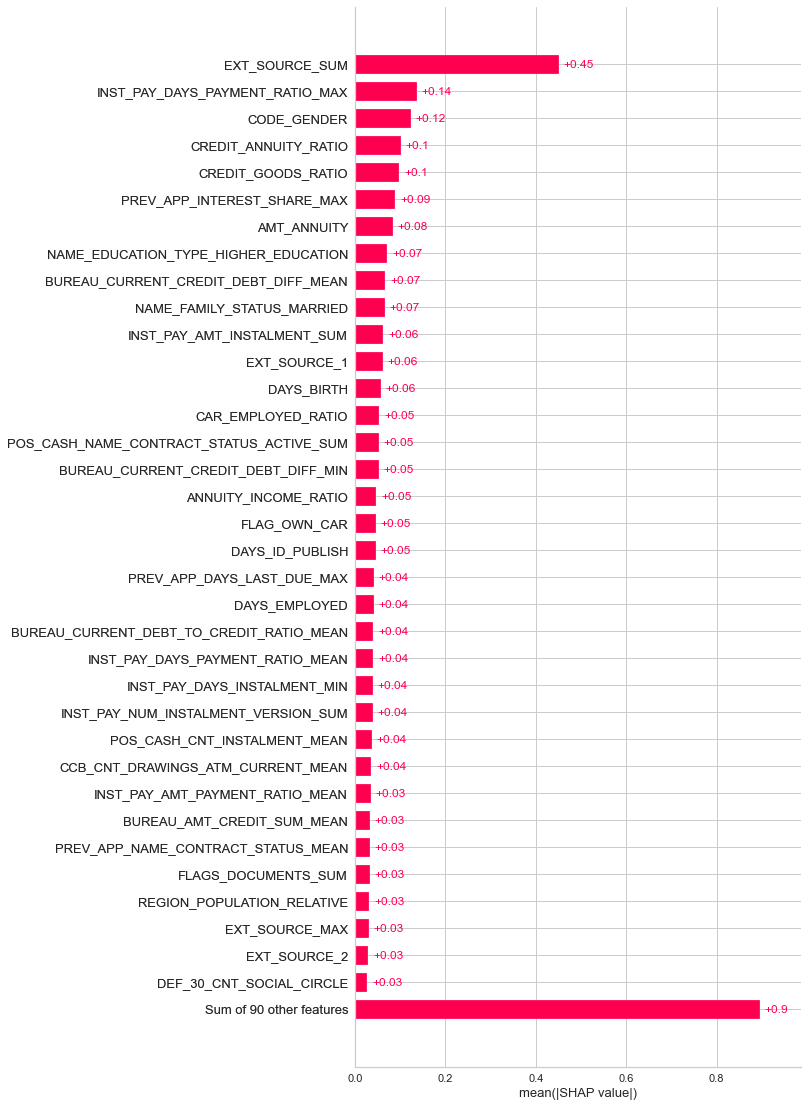

In [154]:
shap.plots.bar(shap_values, max_display=36)

**Beeswarm** : 
- ce graphique est conçu pour afficher un résumé dense en informations de la manière dont les principales caractéristiques d'un ensemble de données influencent la sortie du modèle. 
- Chaque instance de l'explication donnée est représentée par un seul point sur chaque graphique de caractéristiques. La position x du point est déterminée par la valeur SHAP (shap_values.value[instance,feature]) de cette caractéristique, et les points s'empilent le long de chaque ligne de caractéristique pour montrer la densité. 
- La couleur est utilisée pour afficher la valeur originale d'une caractéristique (shap_values.data[instance,feature]). 

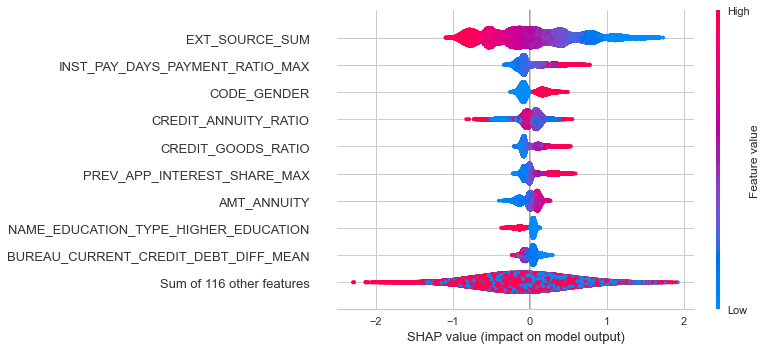

In [155]:
shap.plots.beeswarm(shap_values)

- Dans le graphique ci-dessous, nous pouvons voir que la variable EXT_SOURCE_SUM est la caractéristique la plus importante en moyenne, et que les hautes valuers (en rouge) ont tendance avoir un impact négatif donc classe 1 défaillant alors que les basses valeurs ont tendance à avoir un impact postif donc classe 0 non-défaillant...